## Week 4: Gradients and Optimization

### Outline
- Gradient descent
- Local minima
- Problems of dimension
- Types of differentiation

In [16]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

%matplotlib notebook
%matplotlib notebook
sns.set(font_scale=1.)
sns.set_style('white')

### Gradient Descent


Remember that cost functions are scalar functions, $f: \mathbb{R}^N\rightarrow\mathbb{R}$. Their inputs typically consist of model outputs (and by extension, model inputs) and other data related to the learning method (e.g. target outputs in supervised learning).   

As a toy example, we will start by defining a cost function with a simple, known form:

$$L(\theta) = \theta^2$$

Remember that the cost function may also be called the loss, which is the origin of the notation $L(\cdot)$. Don't confuse this with the likelihood, which is typically written $\mathcal{L}(\cdot)$.

In [2]:
def cost(theta):
    cost = theta ** 2
    return cost

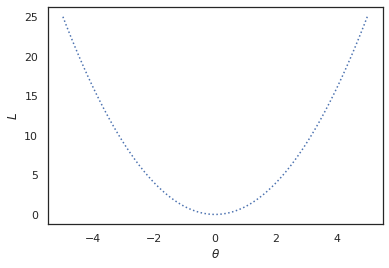

In [3]:
bounds = (-5, 5)
N_plot = 100

def get_cost_curve(cost, bounds, n):  
    """For plotting."""
    thetas = np.linspace(*bounds, n)
    costs = cost(thetas)
    return np.array((thetas, costs))

cost_curve = get_cost_curve(cost, bounds, N_plot)

fig, ax = plt.subplots()
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$L$')
ax.plot(*cost_curve, ':')
plt.show()

It's pretty obvious what the minimum is, and we can solve it analytically with almost no effort.

\begin{align}
\frac{dL}{d\theta} &= 2\theta \\
0 &= 2\theta \\
0 &= \theta
\end{align}

In [4]:
def cost_d(theta):
    cost_d = 2 * theta
    return cost_d

Let's say we _can't_ solve it by setting to 0, as is usually the case, and assume it's too costly to check every possible grid point. 

How do we intelligently choose how to move around the space of parameters (x axis, in the figure above)? Typically we can estimate the cost function and its derivative at chosen points—but not _most_ of them.

In [5]:
def tangent(theta, cost, cost_d=None, scale=0.5):
    """Return vectors of 2D coordinates for a tangent to the `cost`. 
    
    Args:
        theta (float): Value of interest of the parameter of the function `cost`.
        cost (function): Function of theta. Scalar.
        cost_d (function):  Function returning the derivative (by theta) of `cost`.
        scale (float): Scaling factor for the tangent line. (Compare learning rate.)
    """
    m = cost_d(theta)
    cost_i = cost(theta)

    dtheta = -m / np.sqrt(m ** 2 + 1)
    thetas = [theta, theta + dtheta]
    costs = [cost_i, cost_i + m * dtheta]
    
    return thetas, costs

Derivative of cost: 8


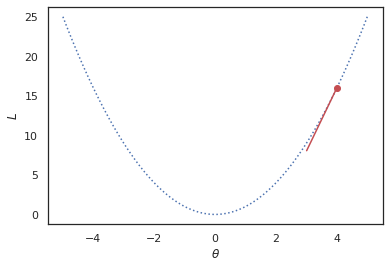

In [7]:
theta_0 = 4  # starting point
cost_0 = cost(theta_0)
print("Derivative of cost: {}".format(cost_d(theta_0)))

fig, ax = plt.subplots()
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$L$')
ax.plot(*cost_curve, ':')
ax.plot(theta_0, cost_0, 'ro')  
ax.plot(*tangent(theta_0, cost, cost_d), 'r')
plt.show()

The derivative at this point is 8. This is positive, so if we move in the direction of positive $\theta$, the cost will increase. This is the opposite of what we want. 

The sign (positive or negative) of the derivative is the opposite of the sign of the quantity we need to add to the parameter $\theta$ to minimize it. (Verify for yourself.) But by how much? Say we move by -8. 

<img src='./img/tangent-1.png'>

Our new position is $\theta=-4$, and the derivative is -8. Clearly if we move by $\Delta\theta=-(-8)=+8$, we'll be back where we started. Unless we take smaller steps, we'll never reach the minimum. 

There is no obvious connection between the magnitude of the derivative and the magnitude of the step we should take. Consider that if the cost has units $[L]$ and $\theta$ has units $[\theta]$, the derivative of the cost has units $[L]/[\theta]$, which are not additive with units of $[\theta]$. The sign tells us what direction to take to find the minimum, but not how far to go. That is usually unknown.

Therefore, to control how far to move, we take steps of $\eta\frac{dL}{d\theta}$, where $\eta$ is the factor (called the *learning rate*) by which we scale the derivative to calculate our step size. 

In this case, it seems reasonable to choose a value $0<\eta<1$. Let's say we start at our original point and choose $\eta=0.25$. (In this case $\eta=0.5$ is optimal since a step size of $0.5(8)=4$ will land us right on the minimum—but we don't normally have this information!)

In [8]:
learn_rate = 0.25

Our update rule is:
$$\theta_{i+1}=\theta_i - \eta\frac{dL}{d\theta}$$

In [9]:
def derivative_step(theta, cost_d, learn_rate): 
    """Update the parameter `theta` by gradient descent."""
    theta = theta - learn_rate * cost_d(theta)  # participant
    return theta

Let's manually run some iterations of this update rule, to see what happens at each step. 

We'll avoid iterating in a loop, for now. Instead, iterations will be run by executing the same notebook cell repeatedly, with the values of the variables _theta_ and _cost\__ remembering our current state between iterations. 

First, we'll set these variables to their initial values (re-run this cell later if you want to reset the iterations):

In [10]:
# start the iterations (steps) at our original estimate
theta = theta_0
cost_ = cost(theta)

Now, our iteration cell:

Derivative of cost: 4.0
Change in cost across step: -12.0


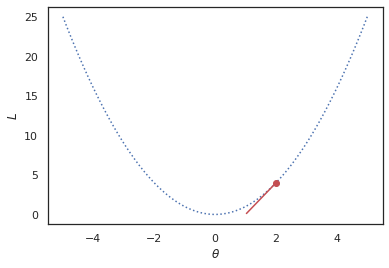

In [11]:
# single step per cell execution
cost_before = cost_ 
theta = derivative_step(theta, cost_d, learn_rate)  # participant
cost_ = cost(theta)

cost_change = cost_ - cost_before

print("Derivative of cost: {}".format(cost_d(theta)))
print("Change in cost across step: {}".format(cost_change))

fig, ax = plt.subplots()
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$L$')
ax.plot(*cost_curve, ':')
ax.plot(theta, cost_, 'ro')
ax.plot(*tangent(theta, cost, cost_d), 'r')
plt.show()

This optimization is an example of Zeno's paradox. We'll never quite reach the minimum (at a constant learning rate), but we can get close enough for any practical purpose. We can decide to stop the optimization based on some measure of "close enough".

Now we'll include some functions to automate these iterations and animate the plotting, so we can investigate arbitrary 1D descent problems without having to repeat the plotting steps, manual iterations, etc. We'll take a _tolerance_ as an input parameter; this will control how small the change in cost must be between iterations, before we stop.

In [12]:
def descent_points(theta_0, cost, cost_d, learn_rate, steps=None, tol=1e-6):
    """Generate a series of points by gradient descent.
    
    Stop after achieving tolerance, or a fixed number of steps.
    """
    # entries for initial estimates
    thetas = [theta_0]
    costs = [cost(theta_0)]
    
    # iterate forever, until either tolerance or #steps criteria met
    while True:
        thetas.append(derivative_step(thetas[-1], cost_d, learn_rate))
        costs.append(cost(thetas[-1]))
        
        # exit loop if either stopping condition is met
        if len(thetas) == steps:
            break
        else:
            if np.abs(costs[-1] - costs[-2]) < tol:
                break
    
    # return as an (N x 2) array of points.
    return np.transpose((thetas, costs))

def descent_tangents(points, cost, cost_d):
    """Prepare tangent endpoints (for plotting) for a series of points on a cost function."""
    steps = len(points)
    # pre-allocate; each tangent requires a 2 endpoints with 2 coordinates each
    tangents = np.zeros((steps, 2, 2))
    for j in range(steps):
        tangents[j, :] = tangent(points[j, 0], cost, cost_d)
    return tangents

In [13]:
def descent_plot_prep(theta_0, bounds, cost, cost_d, learn_rate, steps=None, tol=1e-6):
    """Prepare points, tangents, and cost curve for a gradient descent optimization."""
    points = descent_points(theta_0, cost, cost_d, learn_rate, steps=steps, tol=tol)
    tangents = descent_tangents(points, cost, cost_d)
    curve = get_cost_curve(cost, bounds, N_plot)
    return points, tangents, curve

In [14]:
def animate_descent(points, tangents=None, curve=None, **kwargs):
    """Animate a series of gradient descent points, with tangents and cost curve if provided."""
    fig, ax = plt.subplots()
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'$L$')
    
    if curve is not None:
        cost_curve = ax.plot(*curve, ':')
    estimate, = ax.plot(*points[0], 'ro')
    if tangents is not None:
        tangent, = ax.plot(*tangents[0], 'r')
    
    # matplotlib animations are based on a plot update function
    def animate(i): 
        estimate.set_data(*points[i])  # participant
        if tangents is not None:
            tangent.set_data(*tangents[i])
        return estimate, tangent
    
    # construct the matplotlib animation object
    # any additional keyword arguments passed to `animate_descent` will be forwarded to `FuncAnimation`
    anim = FuncAnimation(fig, animate, blit=True, **kwargs)
    return anim

Note that it's best practice to separate algorithmic logic from specific values of variables. This tends to make code more general, and easier to read. For example, in `animate_descent`, specific axis labels are hard-coded, instead of input by the user, which makes this function less useful in other contexts.

Now we only have to specify the parameters followed by a couple lines of code.

<IPython.core.display.Javascript object>


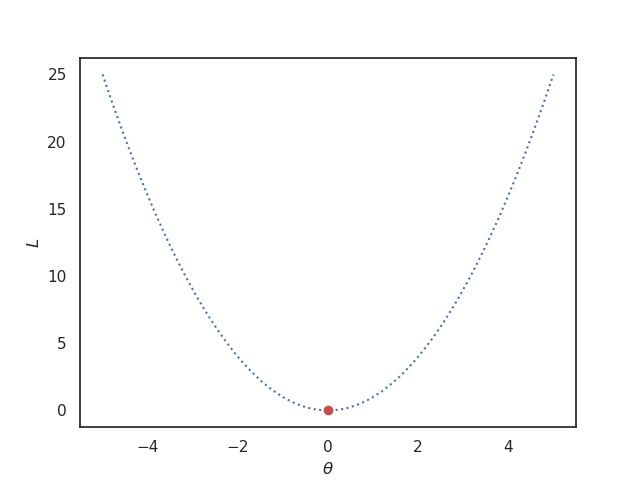

In [17]:
theta_0 = 4
learn_rate = 0.1
tol = 1e-6
bounds = (-5, 5)
interval = 500  # higher = longer delay between animation frames

points, tangents, curve = descent_plot_prep(theta_0, bounds, cost, cost_d, learn_rate, tol=tol)
anim = animate_descent(points, tangents, curve, interval=interval)
plt.draw()

What happens if you change the learning rate? The starting point? Tolerance?

### Local minima

Let's define a more complex polynomial cost function:

In [19]:
def cost(theta):
    cost = (0.066 * theta**4) + (-0.32 * theta**3) + (-0.85 * theta**2) + (4.2 * theta) + 8.2
    return cost

In [20]:
def cost_d(theta):
    cost_d = (0.264 * theta**3) + (-0.96 * theta**2) + (-1.7 * theta) + 4.2  # participant
    return cost_d

It's going to be tedious and messy if we need to manually write such functions for each example of a polynomial function.

It's good practice to _generalize_ your code. This means functions should not be defined on information specific to a single dataset or example—in this case, the number and value of coefficients for a particular polynomial function—but by their analytical logic. The specific information then remains separate, as an input from the user when applying the analysis to a particular example.

In [21]:
def get_polynomial(coefs):
    """Given a list of coefficients, return a polynomial function and its derivative function.
    
    Note that `coefs` should be ordered from lowest- to highest-order terms: intercept,
    then linear term coefficient, quadratic, cubic, etc. All terms from the intercept to the 
    highest-order term of interest must be included.
    """
    def polynomial(theta):
        poly = np.sum([coef * theta**i for i, coef in enumerate(coefs)], axis=0)
        return poly
    def derivative(theta):
        poly_d = np.sum([(coef * (i + 1) * theta**i) for i, coef in enumerate(coefs[1:])], axis=0)  # participant
        return poly_d
    return polynomial, derivative

Now we can simply change a set of input coefficients, without re-defining any functions:

In [22]:
coefs = [8.2, 4.2, -0.85, -0.32, 0.066]

cost, cost_d = get_polynomial(coefs)

This is a quartic polynomial. Let's see what it looks like.

<IPython.core.display.Javascript object>


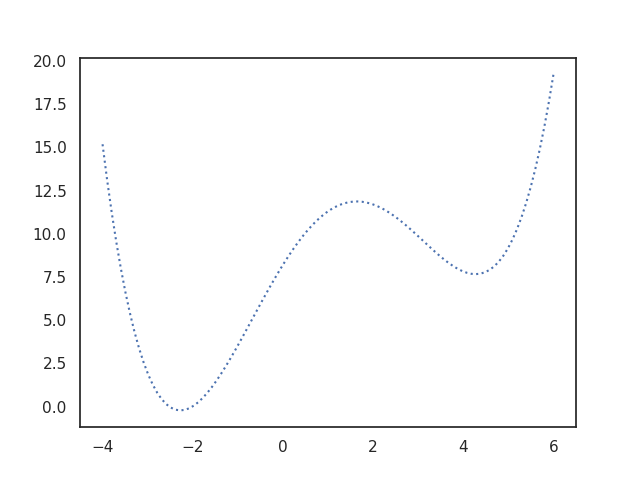

In [23]:
bounds = (-4, 6) 

theta_grid = np.linspace(*bounds, N_plot)

plt.plot(theta_grid, cost(theta_grid), ':')
plt.show()

This function has two minima, but only one is a _global_ minimum. (Which?)

Let's see what happens if we perform gradient descent to the same tolerance used in the quadratic example, once again starting from a high value of `theta`. For the first run, we'll use a smaller learning rate than before.

<IPython.core.display.Javascript object>


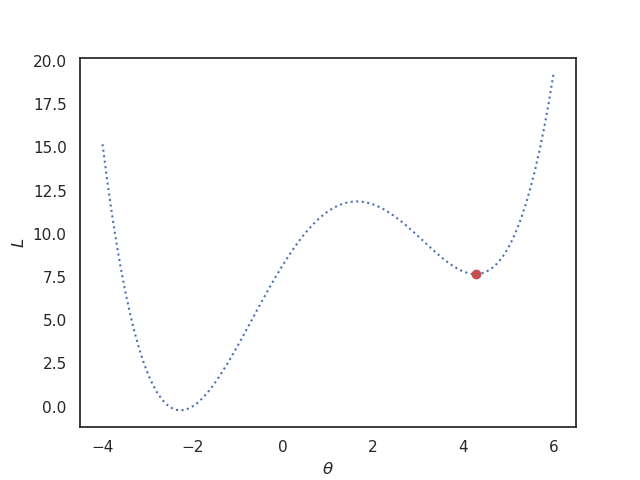

In [24]:
theta_0 = 6
learn_rate = 0.1
tol = 1e-6

points, tangents, curve = descent_plot_prep(theta_0, bounds, cost, cost_d, learn_rate, tol=tol)
anim = animate_descent(points, tangents, curve, interval=interval)
plt.draw()

What happens if you change the learning rate? The starting point? Tolerance?

How can we avoid these kinds of traps?
- Adapt learning rate. 
  - Too low: Inefficient (slow).
  - Too high: Unstable (variable).    
    $\rightarrow$ Speed-accuracy tradeoff.
- More complex exploration strategies.
  - Stochasticity.
  - Higher-order methods.

### Cost functions
- May be hard to differentiate.
- Vary between models.
- Supervised learning: distance between model output and target.
  - Usually not solvable due to non-linearities in model output.

Remember from week 2: linear regression using MSE = quadratic cost function with analytic solution.
$$\nabla_w\textrm{MSE} = 0$$
$$\nabla_w\frac{1}{m}\sum_i(\hat{y}_i-y_i)^2 = 0$$
$$ ... $$
$$w = (X^TX)^{-1}X^Ty$$

<img src="./img/linreg_weight.png">

This resulted in a cost function with an implicitly ~quadratic shape. Typically, the shape of the cost function emerges implicitly by measuring something about model outputs, such as their distance from known outputs. 

<img src="./img/linreg_mse.png">

However, models may be very complex, non-linear, and measures on their outputs may be hard to describe in terms of simply differentiable functions, as we have done in this tutorial for the sake of clarity.

### Multidimensional case
- Curse of dimensionality: 
    - Relatively easy to check the entire domain of model parameters in the 1D case.
    - BUT difficulty grows exponentially with number of dimensions.    
    $\rightarrow$ increased importance of intelligent strategies     
       
       
- Gradient (vector of partial derivatives) instead of simple derivative
    - Similar reasoning as the 1D case, given the sign of the partial derivatives in each direction.
    - *Relative* magnitudes of different parts of the gradient matter for direction of max descent. 

### The Jacobian matrix
$$
\mathbf{J}
=
\frac{d \mathbf{f}}{d \mathbf{x}}
=
\left[ \frac{\partial \mathbf{f}}{\partial x_1}
\cdots \frac{\partial \mathbf{f}}{\partial x_n} \right]
=
\begin{bmatrix}
\frac{\partial f_1}{\partial x_1} & \cdots &
\frac{\partial f_1}{\partial x_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial f_m}{\partial x_1} & \cdots &
\frac{\partial f_m}{\partial x_n}
\end{bmatrix}
$$

Analogue for second partial derivatives: Hessian matrix.

### Complex loss functions
<img src='./img/nn_landscapes.png'>
(see https://www.cs.umd.edu/~tomg/projects/landscapes/)

### Types of differentiation
#### Symbolic
- As above.
- Limitations:
  - Manual effort (+ math skills) for individual models.
  - Difficult to automate directly.   
  
#### Numerical
- Typically finite differences or extensions
  i.e. evaluate cost at small steps surrounding current point to approximate slope.    
- Limitations: 
  - Inefficient.    
  
#### Automatic
- Based on chain rule     
  $\rightarrow$ when functions can be decomposed into simpler parts, so can their derivatives.    
- Limitations:
  - Implicit?

### Stochastic gradient descent
- Use subsets of dataset rather than full dataset---computational limitations
- Approximation of "true" gradient